In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='b2f906e8-963e-46de-b4ea-10dddd314d57', project_access_token='p-8b6a1b568ba6eebb5988bf98c9a72946fc2a2383')


# Data Exploration: Fashion-MNIST Data

This notebook explores the [Fashion-MNIST dataset from the Data Asset Exchange](https://developer.ibm.com/exchanges/data/all/fashion-mnist/) on IBM Developer. This dataset contains 60,000 training images and 10,000 test images of fashion and clothing items, taken from 10 categories, such as shirts and dresses. Each image is in grayscale and 28 by 28 pixels in size. [Fashion-MNIST was created by Zalando Research](https://www.kaggle.com/zalando-research/fashionmnist) as a compatible replacement for the original MNIST dataset of handwritten digits. This version of the dataset has been converted to CSV to enable easier loading in common data science tools. 

In this notebook, we explore the training dataset `fashion-mnist_train.csv` by:
- Encoding label features
- Inspecting data through visualizations


### Table of Contents:
* [0. Prerequisites](#section0)
* [1. Loading the Data](#section1)
* [2. Exploring the Data](#section2)
  * [2.1 Display information about the dataframe](#section3)
  * [2.2 Inspect the labels](#section4)
* [3. Visualizing the Data](#section5)
  * [3.1 Visualize the training images](#section6)
  * [3.2 Visualize using Principal Component Analysis](#section7)
  * [3.3 Visualize using t-Distributed Stochastic Neighbouring Entities](#section8)
* [Authors](#authors)

<a id="section0"></a>
### 0. Prerequisites

Before you run this notebook complete the following steps:
- Insert a project token
- Import required packages

#### Insert a project token

When you import this project from the Watson Studio Gallery, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the dataset from the project's resources:

* Click on `More -> Insert project token` in the top-right menu section

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

#### Import required packages

Import and configure the required packages, including [`pandas`](https://pypi.org/project/pandas/), [`numpy`](https://pypi.org/project/numpy/), and [`matplotlib`](https://pypi.org/project/matplotlib/).

In [2]:
# Define required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a id="section1"></a>

### 1. Loading the Data

We start by reading in the training dataset from `fashion-mnist_train.csv` into a Pandas DataFrame and previewing the first few rows.

In [3]:
# define filename
DATA_PATH = 'fashion-mnist_train.csv'

# Create method to find filepath based on filename
def get_file_handle(fname):
    # Project data path for the raw data file
    data_path = project.get_file(fname)
    data_path.seek(0)
    return data_path

# Using pandas to read the data 
data_path = get_file_handle(DATA_PATH)
data = pd.read_csv(data_path)
# Display the first five rows
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The table above displays the first 5 rows of the data frame. Each row of this data frame contains information about an "image". The first column named `label` identifies the clothing item that is depicted in the image. The other 784 columns named `pixel` represent the image. 

The mapping between the numeric value in the `label` column and the category is not included in the dataset, but defined as follows:
- 0 - T-shirt/top <br /> 
- 1 - Trouser <br /> 
- 2 - Pullover <br /> 
- 3 - Dress <br /> 
- 4 - Coat <br /> 
- 5 - Sandal <br /> 
- 6 - Shirt <br /> 
- 7 - Sneaker <br /> 
- 8 - Bag <br /> 
- 9 - Ankle boot 


For example, in row 0 (the first row), the numeric label value is 2, which represents a pullover.


<a id="section2"></a>

### 2. Exploring the Data

As shown above, the mini dataset of 5 images is a matrix with 5 rows and 785 columns. Displaying it as matrix is not very informative as each cell is a pixel and as such is not human-readable. To better understand what each pixel represents, we need to convert it to a weighted form. Further investigation of the data such as shape, dimensions and labels of the data is necessary and so is the visualization. This section explores them in detail.

<a id="section3"></a>
#### 2.1 Display information about the dataframe
First, we collect basic information about the dataframe, such as the number of rows and the number of features.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


The dataframe statistics indicate that there are 60,000 rows and 785 features in the training dataset. Each row represents an image that will be used during model training.

<a id="section4"></a>
#### 2.2 Inspect the labels

Let's count the unique number of labels in the training dataset.

In [5]:
# count total number of unique values in the `label` column
len(data['label'].unique())

10

Next, let's find out how many images the training dataset includes for each label.

In [6]:
# Number of data points under each label
data['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

We can see that there are 6,000 images associated with each label, for a total of `10 * 6000 = 60000` pictures. This is a balanced dataset in terms of class distribution.

<a id="section5"></a>
### 3.Visualizing the Data

Before we can visualize the data we need to review how it is encoded.

The 784 `pixelXXX` column values in each row contain brightness information for each pixel in the 28x28 grayscale image. The pixel brightness is stored as an 8-bit integer, ranging from 0 (typically representing black) to 255 (white). Values in between represent different shades of gray. To normalize the values, we therefore need to divide each `pixelXXX` cell by 255. You can learn more about pixel values on [this page](https://homepages.inf.ed.ac.uk/rbf/HIPR2/value.htm).

In [9]:
# Save the data points as 'input_data'
input_data = data.iloc[:,1:] / 255
# Check the shape of the input data
print('Shape of the input data',input_data.shape)
# Preview a few rows
input_data.head()

Shape of the input data (60000, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


The generated `input_data` dataframe contains the label and normalized pixel values. The number of rows and columns in the dataframe has not changed. <br>
Next, we create another dataframe named `target`, which only includes the numeric labels.

In [11]:
# Save the label(in 0-9 format) as 'target'
target = data[['label']].iloc[:, :]
# Check the shape of the label/category
print('Shape of the input label', target.shape)
# Preview a few rows
target.head()

Shape of the input label (60000, 1)


,label
0,2
1,9
2,6
3,0
4,3


Since numeric labels are not that meaningful in a visualization, we'll map them to a textual representation using a lookup:
- 0 => T-shirt/top <br /> 
- 1 => Trouser <br /> 
- 2 => Pullover <br /> 
- 3 => Dress <br /> 
- 4 => Coat <br /> 
- 5 => Sandal <br /> 
- 6 => Shirt <br /> 
- 7 => Sneaker <br /> 
- 8 => Bag <br /> 
- 9 => Ankle boot 

In [12]:
# Manually enter the meaningful name of each label
label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

We save the meaningful labels as `label` for later visualization purposes.

<a id="section6"></a>
#### 3.1 Visualize the training images

First, let's take a look at the pictures. We are using matplotlib to draw the first 30 training images in the `input_data` dataframe along with their label.

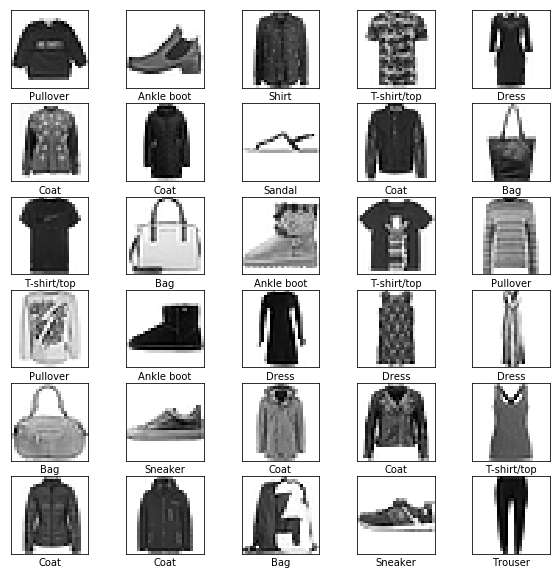

In [13]:
# Set the figure size
plt.figure(figsize=(10,10))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(input_data.iloc[i, :]).reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(label[target.label.iloc[i]])

<a id="section7"></a>
#### 3.2 Visualize using Principal Component Analysis

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is a statistical procedure for reducing the number of dimensions in a dataset whilst retaining most information. It is extensionally used for dimension reduction, especially for high-dimension data. 

By calculating and comparing correlations between dimensions, this method provides a minimum number of variables that keep the maximum amount of variation(explanation) about how the original data is distributed. In other words, it skips the dimensions that have less explained variance and keeps the more meaningful ones.

Import and configure the required packages: print_function, time, fetch_mldata, PCA, TSNE, Axes3D, sns

In [14]:
from __future__ import print_function
import time
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import decomposition
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

We convert the matrix and vector to a Pandas DataFrame named `pca_df` and name the 784 pixel columns as `features` for simplicity to call multiple columns at once.

In [16]:
# Give multiple pixel columns one name: features
features = ['pixel' + str(i+1) for i in range(input_data.shape[1]) ]
#print('What is features?', features)
# Create a new DataFrame df
pca_df = pd.DataFrame(input_data, columns=features)
# Add an additional column 'y', identical with label values in data
pca_df['label'] = target['label']

print('Size of the dataframe: {}'.format(pca_df.shape))

Size of the dataframe: (60000, 785)


Loop through the labels and convert them to meaningful labels. For example, from 0 to `T-shirt/top`, 1 to `Trouser`, etc.

In [17]:
# Create an empty list which will save all meaningful labels
results = []
# Loop through all label
for i in range(pca_df.shape[0]):
    # Extract the label for comparison
    if pca_df['label'][i] == 0:
        # Save meaningful label to the results
        results.append('T-shirt/top')
    # Following the same code pattern as the one above
    elif pca_df['label'][i] == 1:
        results.append('Trouser')
    elif pca_df['label'][i] == 2:
        results.append('Pullover')
    elif pca_df['label'][i] == 3:
        results.append('Dress')
    elif pca_df['label'][i] == 4:
        results.append('Coat')
    elif pca_df['label'][i] == 5:
        results.append('Sandal')
    elif pca_df['label'][i] == 6:
        results.append('Shirt')
    elif pca_df['label'][i] == 7:
        results.append('Sneaker')
    elif pca_df['label'][i] == 8:
        results.append('Bag')
    elif pca_df['label'][i] == 9:
        results.append('Ankle boot')
    else:
        print("The dataset contains an unexpected label {}".format(pca_df['label'][i]))

# Create a new column named result which has all meaningful results        
pca_df['result'] = results

In [19]:
pca_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label,result
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2,Pullover
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,9,Ankle boot
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0,6,Shirt
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0,0,T-shirt/top
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,3,Dress


In this notebook we use the [Scikit-Learn implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to generate two and three dimensional plots from the original 784 dimensions (each pixel is a dimension), so we choose `n_components = 3`, the first three principal components. Let's see how much variation in the total dataset is explained by these principal components.

In [20]:
# Set first three principle components
pca = PCA(n_components=3)
# Fit the model with pixel columns and apply the dimensionality reduction on those columns
pca_result = pca.fit_transform(pca_df[features].values)

The `pca.explained_variance_ratio_` parameter returns a vector of the variance explained by each dimension. 

In [21]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.29011353 0.17727668 0.060227  ]


Append the three dimensional PCA values as columns to the `pca_df` dataframe, naming them `First Dimension`, `Second Dimension`, and `Third Dimension`.

In [22]:
pca_df['First Dimension'] = pca_result[:,0]
pca_df['Second Dimension'] = pca_result[:,1] 
pca_df['Third Dimension'] = pca_result[:,2]

In [23]:
# Preview the first few rows in the `pca_df` data frame.
pca_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel780,pixel781,pixel782,pixel783,pixel784,label,result,First Dimension,Second Dimension,Third Dimension
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,2,Pullover,3.686333,4.960529,-0.051232
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,9,Ankle boot,-4.376434,3.861059,-1.949433
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,6,Shirt,7.265152,1.568757,2.315239
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.003922,0.0,0.0,0.0,0.0,0,T-shirt/top,3.227788,-2.325256,-0.649302
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,3,Dress,4.146373,-4.039080,-1.515247


Now, let's visualize the first 3 principle vectors in the principle component analysis.

Text(0.5, 0.98, '3-Component PCA')

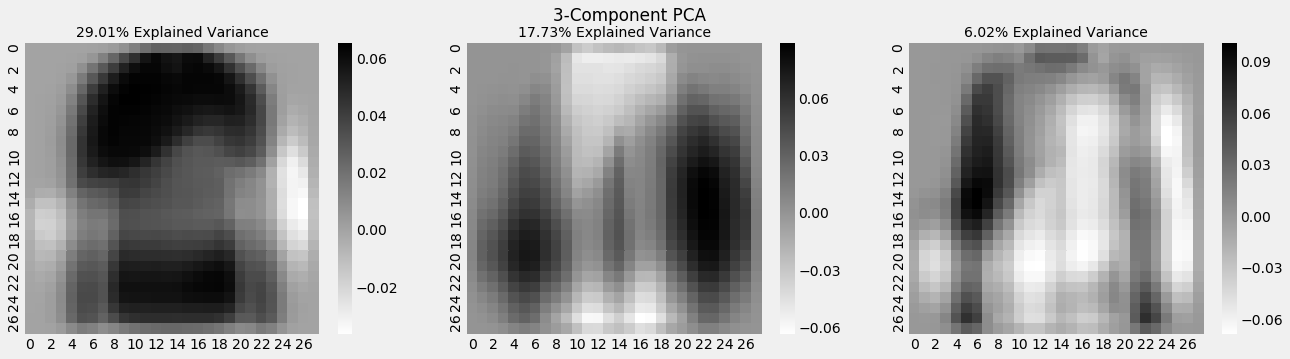

In [24]:
# Set the graph style as 'fivethirtyeight'
plt.style.use('fivethirtyeight')
#Set figure size
fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
# use seaborn heatmap to visualize the first three pca components
sns.heatmap(pca.components_[0, :].reshape(28, 28), ax=axarr[0], cmap=plt.cm.binary)
sns.heatmap(pca.components_[1, :].reshape(28, 28), ax=axarr[1], cmap=plt.cm.binary)
sns.heatmap(pca.components_[2, :].reshape(28, 28), ax=axarr[2], cmap=plt.cm.binary)
# Set picture title to explained variance
axarr[0].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100), fontsize=14)
axarr[1].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100), fontsize=14)
axarr[2].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100), fontsize=14)
# Add picture title
plt.suptitle('3-Component PCA')

Each component is an eigenvector. The first component looks like a T-shirt and a shoe. The second component is a trouser and a pullover. The third component looks like a pullover and an ankle boot.

The first dimension explains 29% of the pixel data, the second dimension explains approximately 17%, while the third dimension explains only 6%. Each additional dimension added to the PCA explains less variance of the data. If the number of component is 784, the cumulative explained variance would be 100%. But reaching 100% explained variance requires too much work, we rather do dimension reduction and sacrifice some explained variance for the sake of efficiency. 

It's crucial to pick a relatively small number of components while keep the effectiveness of the model. Let's plot the cumulative explained variance ratio for all components of the principle component analysis. To do this, we can clearly see changes of explained variance with the increase in number of components.

In [25]:
# initializing the pca
# Set n_components as 784 dimensions
pca = decomposition.PCA(n_components = 784)
# Fit on training data
pca_784 = pca.fit_transform(pca_df[features].values)
#percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
var_ratios = np.cumsum(pca.explained_variance_ratio_)

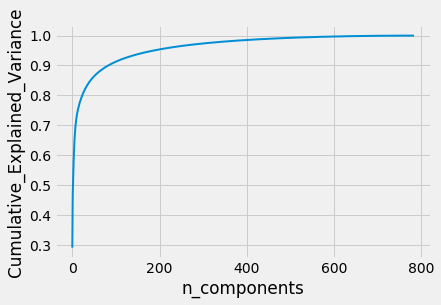

In [26]:
# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(var_ratios, linewidth=2)
plt.xlabel("n_components")
plt.ylabel("Cumulative_Explained_Variance")
plt.show()

From the graph above, we see that 200 components explain approximately 95% variance and 80 components explain 90% variance. As the number of components increase, the explained variance rises to 100%, which makes sense because it is original matrix with 784 dimensions.

You can try `n_components = 10` or `n_components = 20` to further analysis.

Plot the first two dimensions from the `pca_df` dataframe. Each color represents a label.

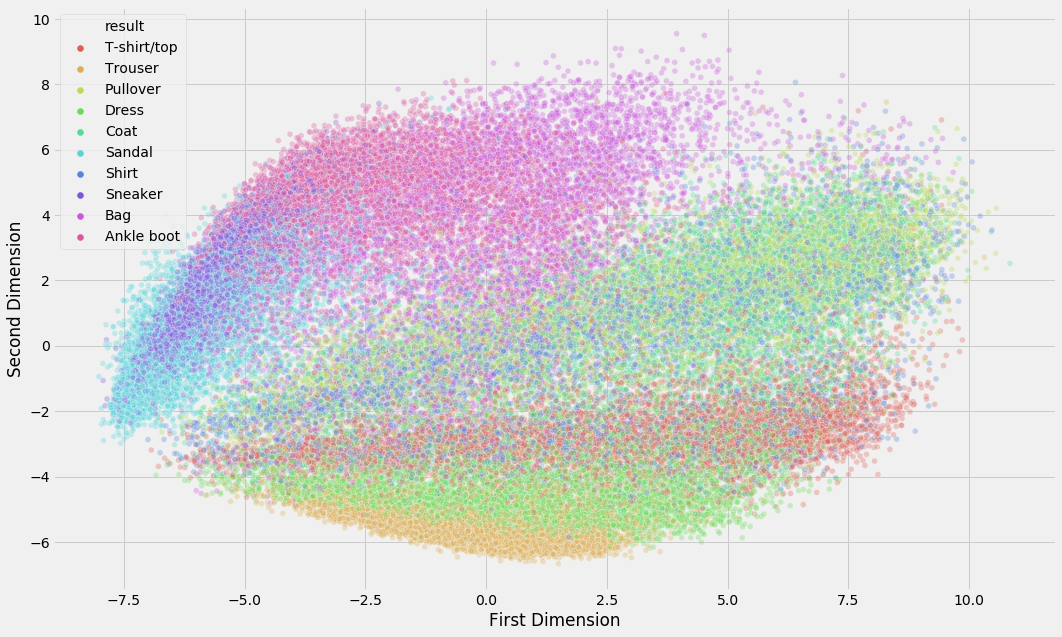

In [27]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="First Dimension", y="Second Dimension",
    hue = "result",
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    alpha=0.3
)

From the graph above, we can see the two components can separate different categories apart to some degree, but the separation is not clear enough. Let's take a look at the three-dimensional representation.

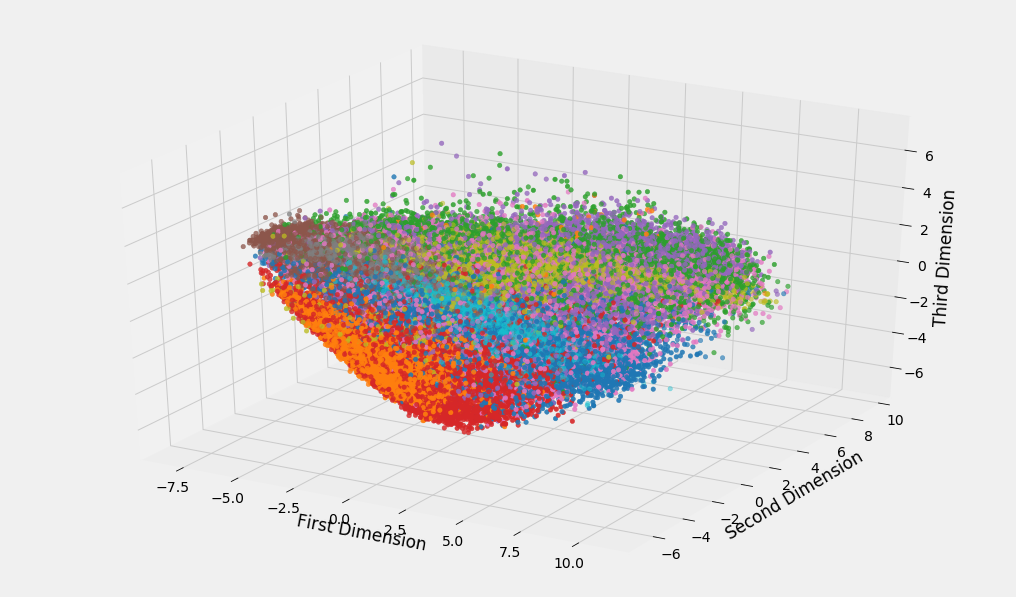

In [28]:
graph = plt.figure(figsize=(16,10)).gca(projection='3d')
graph.scatter(
    xs=pca_df["First Dimension"], 
    ys=pca_df["Second Dimension"], 
    zs=pca_df["Third Dimension"], 
    c=pca_df["label"], 
    cmap='tab10'
)
graph.set_xlabel('First Dimension')
graph.set_ylabel('Second Dimension')
graph.set_zlabel('Third Dimension')
plt.show()

The three-dimensional visualization can also not sufficiently separate the categories. We need a more efficient technique.

<a id="section8"></a>
####  3.3 Visualize using t-Distributed Stochastic Neighbouring Entities

[t-Distributed Stochastic Neighbouring Entities](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE) is a machine learning algorithm that can reduce the number of dimensions more efficiently. The method is particularly good for the visualization of high-dimensional datasets. You can learn more about it in [this paper](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).

In this notebook we use the [Scikit-Learn implementation of t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Because t-SNE is compute intensive we need to reduce the dimensions in this dataset. We'll do that by using a smaller subset of the images in the dataset.

In [29]:
# Create a random generator, so to decreases potential biases in the data
rand = np.random.permutation(pca_df.shape[0])

In [30]:
# Pull 10000 pictures out of the sample
N = 10000
pca_df_subset = pca_df.loc[rand[:N],:].copy()
data_subset = pca_df_subset[features].values

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
pca_df_subset['First Dimension'] = pca_result[:,0]
pca_df_subset['Second Dimension'] = pca_result[:,1] 
pca_df_subset['Third Dimension'] = pca_result[:,2]
print('Explained variation in each principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation in each principal component: [0.2938629  0.17571467 0.06014763]


For this dataset the first dimension explains 28.6% of the pixel data, the second dimension explains 17.9%, and the third dimension explains 6.0%. <br>

Run the t-SNE machine learning algorithm, limiting the number of components to 2, which is all we need for a two-dimensional visualization. This might take a few minutes.

In [31]:
# Keep track of time elapsed in the method
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE finished! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.325s...
[t-SNE] Computed neighbors for 10000 samples in 212.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.786949
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.430428
[t-SNE] KL divergence after 300 iterations: 2.529187
t-SNE finished! Time el

Display the analysis results in a two-dimensional chart.

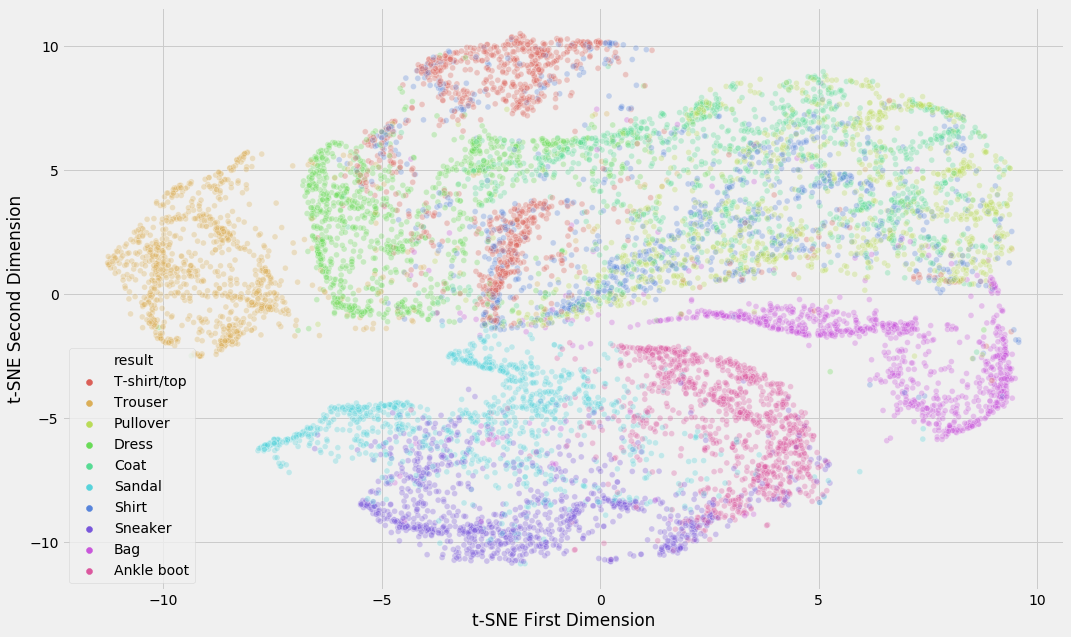

In [32]:
pca_df_subset['t-SNE First Dimension'] = tsne_results[:,0]
pca_df_subset['t-SNE Second Dimension'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="t-SNE First Dimension", y="t-SNE Second Dimension",
    hue="result",
    hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("hls", 10),
    data=pca_df_subset,
    legend="full",
    alpha=0.3
)

In the graph above, it shows a significant improvement in classification compared to PCA visualization. 

Each category is clearly clustered in its own region. For example, on the left bottom side, `Trouser` is successfully classified and differentiated from the others. Although the (light green) `Pullover`, (darker green) `Dress`, and (blue) `Shirt` are mixed in cluster as shown in the middle top part of the graph, the t-SNE is able to classify all other 7 categories. Hence, we can say this is a good classification.

#### Next steps

- Close this notebook.
- Open the `Part 2 - ML and Model Evaluations` notebook.

<a id="authors"></a> 
### Authors

This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>